In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
from tqdm import tqdm
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats.multitest
from statsmodels.stats.anova import AnovaRM

from matplotlib.colors import LinearSegmentedColormap, Colormap
from matplotlib.colors import Normalize as Color_Normalize
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.patches import Rectangle

import scipy
from scipy import optimize, stats

import nilearn
from nilearn import plotting
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import pingouin as pg

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# To make plots using Matplotlib, you must first enable IPython's matplotlib mode.
# To do this, run the %matplotlib magic command to enable plotting in the current Notebook.
# This magic takes an optional argument that specifies which Matplotlib backend should be used. 
# Most of the time, in the Notebook, you will want to use the inline backend,
# which will embed plots inside the Notebook:
%matplotlib inline

In [3]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [4]:
dir_root = join('/mnt/ext4/GL/fmri_data')

dir_stat = join(dir_root, 'stats')
stat = 'GLM.reward.4s_shifted.SSKim'
dir_GLM_reward = join(dir_stat, stat)
dir_GLM_movement = join(dir_stat, 'GLM.Move-Stop.SSKim')

dir_mask = join(dir_root, 'masks')

In [5]:
list_subj = [
    'GL03', 'GL04', 'GL05', 'GL06', 'GL07'
    , 'GL08', 'GL09', 'GL10', 'GL11', 'GL12'
    , 'GL14', 'GL15', 'GL16', 'GL17', 'GL18'
    , 'GL19', 'GL20', 'GL21', 'GL22', 'GL24'
    , 'GL25', 'GL26', 'GL27', 'GL29'
]

In [6]:
bg_img = join('/usr/local/afni/abin/MNI152_2009_template.nii.gz')

---

In [7]:
zscore_reward = join(dir_GLM_reward, 'GL.group.Zscore.SetA_Zscr.n24.nii')
zscore_motor = join(dir_GLM_movement, 'GL.group.Zscore.SetA_Zscr.n24.nii')

In [8]:
threshold = 3.291 # This is a z-score for p=0.001
threshold = 3.8906 # This is a z-score for p=0.0001

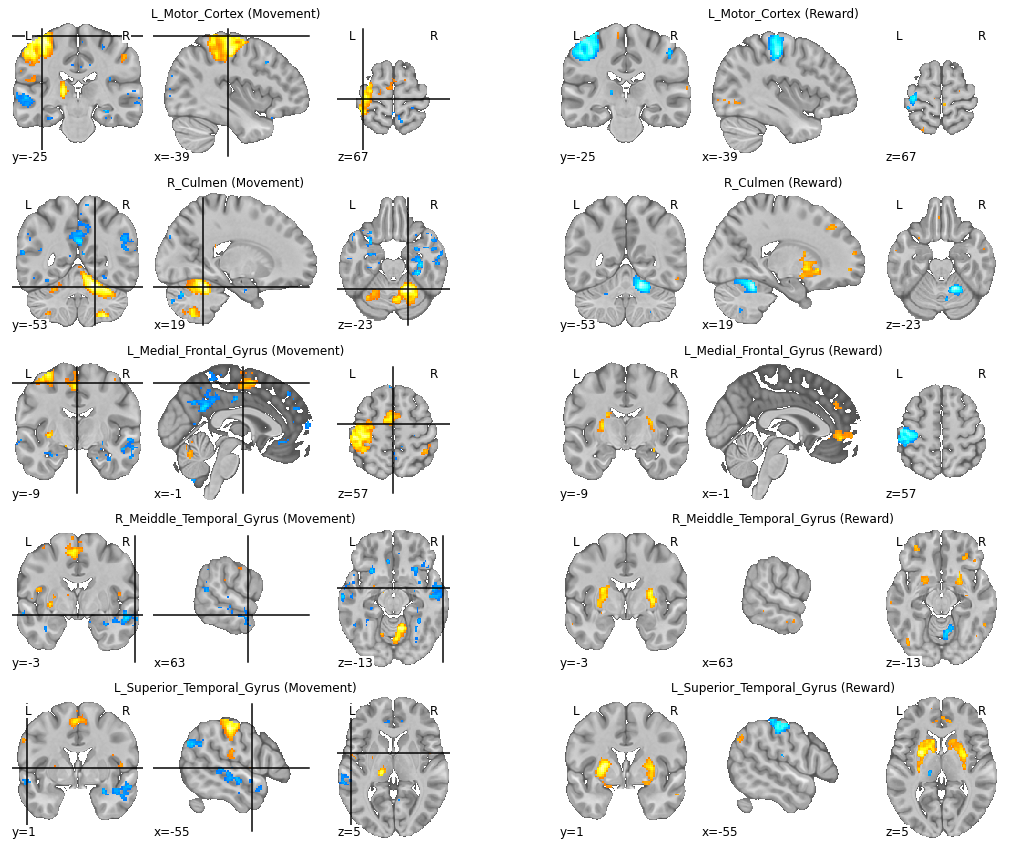

In [9]:
list_coord = {}
list_coord['L_Motor_Cortex'] = (-39,-25,67)
list_coord['R_Culmen'] = (19, -53, -23)
list_coord['L_Medial_Frontal_Gyrus'] = (-1, -9, 57)
list_coord['R_Meiddle_Temporal_Gyrus'] = (63, -3, -13)
list_coord['L_Superior_Temporal_Gyrus'] = (-55, 1, 5)

nrows, ncols = len(list_coord), 2

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols
    , figsize=(9*ncols, 3*nrows)
)
axs = np.concatenate(axs.transpose())
for ii, (region, coord) in enumerate(list_coord.items()):
    ax = axs[ii]
    nilearn.plotting.plot_stat_map(
        stat_map_img=zscore_motor, bg_img=bg_img, black_bg=False
        , threshold=threshold, colorbar=False
        , display_mode='ortho'
        , cut_coords=coord
        , draw_cross=True
        , axes=ax
    )
    ax.set_title('%s (Movement)'%region)
    
    ax = axs[ii+nrows]
    nilearn.plotting.plot_stat_map(
        stat_map_img=zscore_reward, bg_img=bg_img, black_bg=False
        , threshold=threshold, colorbar=False
        , display_mode='ortho'
        , cut_coords=coord
        , draw_cross=False
        , axes=ax
    )
    ax.set_title('%s (Reward)'%region)

fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/results/S2.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

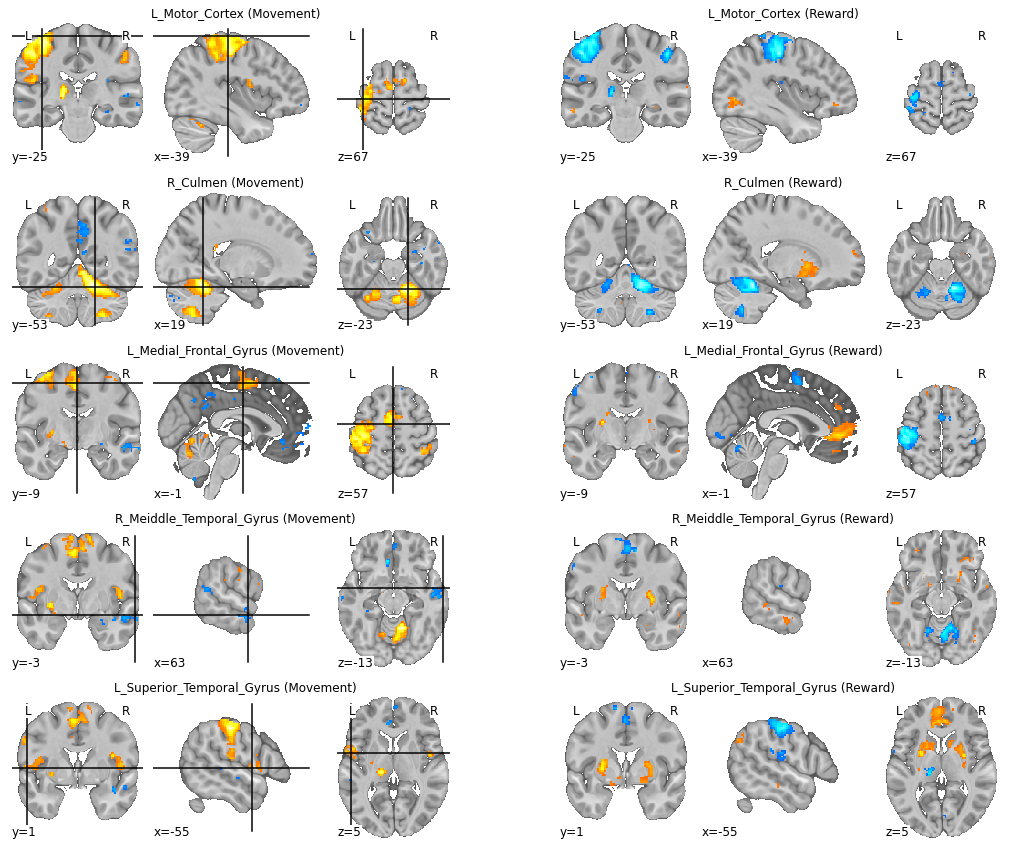

In [9]:
## Source: Sungbeen Park's preprocessed fMRI data

---

In [7]:
img_putamen = join(dir_mask, 'mask.putamen_4parts.nii')
img_caudate = join(dir_mask, 'mask.caudate_4parts.nii')
img_NAc = join(dir_mask, 'mask.NAc_2parts.nii')
img_VmPFC = join(dir_mask, 'mask.VmPFC_16parts.nii')

# img_mask = nilearn.image.math_img(
#     img1=img_putamen, img2=img_caudate, img3=img_NAc, img4=img_VmPFC
#     , formula='(img1+img2+img3+img4) > 0'
# )
# nilearn.plotting.plot_roi(img_mask)

/tmp/ipykernel_2851889/2147935094.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  print(np.unique(img_roi.get_data()))


[0 1]


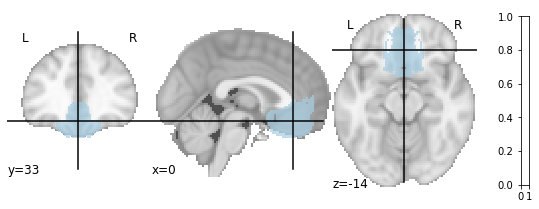

In [22]:
# tmp = nilearn.image.math_img(img1=img_putamen, formula='img1*0')
img_roi = nilearn.image.math_img(
    img1=img_VmPFC
    , formula='img1>0'
)
print(np.unique(img_roi.get_data()))
nilearn.plotting.plot_roi(img_roi, cmap='Paired', colorbar=True)

In [18]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_roi, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['VmPFC']
)

NameError: name 'img_roi' is not defined

In [14]:
dh = pd.DataFrame(columns=['subj', 'source', 'ROI', 'beta'])

In [17]:
df = pd.DataFrame(columns=['subj', 'source', 'ROI', 'beta'])
dg = pd.DataFrame(columns=['subj', 'source', 'ROI', 'beta'])

for ii, subj in enumerate(list_subj):
    ## reward
    img_beta = join(dir_GLM_reward, '%s/%s.Rew#1_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'source':'reward', 'ROI':roi, 'beta':beta}, ignore_index=True)
    ## Move-Stop
    img_beta = join(dir_GLM_movement, '%s/%s.Move-Stop_GLT#0_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        dg = dg.append({'subj':subj, 'source':'move-stop', 'ROI':roi, 'beta':beta}, ignore_index=True)

dh = dh.append(df)
dh = dh.append(dg)
dh

,subj,source,ROI,beta
0,GL03,reward,raPU,0.374774
1,GL03,reward,laPU,0.403717
2,GL03,reward,lpPU,0.241160
3,GL03,reward,rpPU,0.308857
4,GL04,reward,raPU,0.348419
...,...,...,...,...
91,GL27,move-stop,rpPU,-0.030024
92,GL29,move-stop,raPU,0.035417
93,GL29,move-stop,laPU,0.035727
94,GL29,move-stop,lpPU,0.079118


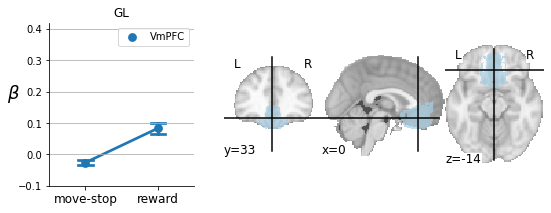

In [27]:
fig = plt.figure(figsize=(12, 3), constrained_layout=False)
gs = fig.add_gridspec(nrows=1, ncols=4)

axs = []
axs.append(fig.add_subplot(gs[0,0]))
axs.append(fig.add_subplot(gs[0,1:3]))

ax = axs[0]
# ax = sns.violinplot(
#     data=dh, x='source', y='beta'
#     , hue='ROI'
#     , ci='sd', capsize=.3
#     , ax=ax
# )
order = ['move-stop', 'reward']
ax = sns.pointplot(
    data=dh, x='source', y='beta'
    , hue='ROI', order=order
    , capsize=0.2, ci=68
    , ax=ax
)

# ## t-test #1
# a = df[(df.source=='reward')&(df.ROI=='putamen')].beta
# b = df[(df.source=='reward')&(df.ROI=='caudate')].beta
# tval, pval = stats.ttest_ind(a,b)
# ax.plot([-.2,-.2],[.8,.86], 'k-')
# ax.plot([.2,.2],[.62,.86], 'k-')
# ax.plot([-.2,.2],[.86,.86], 'k-')
# ax.text(-.04,.89, convert_pvalue_to_asterisks(pval))

# ## t-test #2
# a = df[(df.source=='reward')&(df.ROI=='putamen')].beta
# tval, pval = stats.ttest_1samp(a, popmean=0)
# ax.text(-.33, .72, convert_pvalue_to_asterisks(pval))
# b = df[(df.source=='reward')&(df.ROI=='caudate')].beta
# tval, pval = stats.ttest_1samp(b, popmean=0)
# ax.text(.07, .54, convert_pvalue_to_asterisks(pval))

# ## t-test #3
# a = df[(df.source=='move-stop')&(df.ROI=='putamen')].beta
# b = df[(df.source=='move-stop')&(df.ROI=='caudate')].beta
# tval, pval = stats.ttest_ind(a,b)
# ax.plot([.8,.8],[.35,.38], 'k-')
# ax.plot([1.2,1.2],[.29,.38], 'k-')
# ax.plot([.8,1.2],[.38,.38], 'k-')
# ax.text(.95,.41, convert_pvalue_to_asterisks(pval))

# ## t-test #2
# a = df[(df.source=='move-stop')&(df.ROI=='putamen')].beta
# tval, pval = stats.ttest_1samp(a, popmean=0)
# ax.text(.72, .27, convert_pvalue_to_asterisks(pval))
# b = df[(df.source=='move-stop')&(df.ROI=='caudate')].beta
# tval, pval = stats.ttest_1samp(b, popmean=0)
# ax.text(1.12, .21, convert_pvalue_to_asterisks(pval))

ax.set(ylim=(-0.1, 0.42))
ax.grid(axis='y')
ax.legend(loc='best')
ax.set_ylabel(r'$\beta$', fontsize=18, rotation=0)
ax.set_xlabel('', fontsize=0)
ax.set_xticklabels(order, fontsize=12)
ax.set_title('GL')

sns.despine()

ax = axs[1]
nilearn.plotting.plot_roi(img_roi, cmap='Paired', axes=ax)

# fig.savefig(
#     '/home/sungbeenpark/Github/labs/GL/GL.GLM.striatum.violinplot.png'
#     , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
# )

In [17]:
stats.ttest_1samp(df[df.ROI=='NAc'].beta, popmean=0.)

Ttest_1sampResult(statistic=4.5403710165295195, pvalue=0.00014636502835794444)

In [18]:
a = df[df.ROI=='putamen'].beta
b = df[df.ROI=='NAc'].beta
stats.ttest_ind(a,b)

Ttest_indResult(statistic=2.7302172444482102, pvalue=0.008940778917302307)

---

---

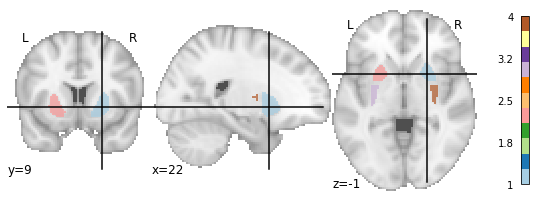

In [7]:
img_putamen = join(dir_mask, 'mask.putamen_4parts.nii')
nilearn.plotting.plot_roi(img_putamen, cmap='Paired', colorbar=True)

In [8]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_putamen, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['raPU', 'laPU', 'lpPU', 'rpPU']
)

In [9]:
df = pd.DataFrame(columns=['subj', 'condition', 'ROI', 'AP', 'LR', 'beta'])
df

,subj,condition,ROI,AP,LR,beta


In [10]:
for subj in tqdm(list_subj):
    ## reward
    img_beta = join(dir_GLM_reward, '%s/%s.Rew#1_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for label, beta in zip(masker.labels, betas):
        ap = 'anterior' if 'a' in label else ('posterior' if 'p' in label else 'invalid')
        lr = 'left' if 'l' in label else ('right' if 'r' in label else 'invalid')
        roi = 'putamen' if 'PU' in label else ('caudate' if 'CN' in label else 'invalid')
        df = df.append(
            {'subj':subj, 'condition':'reward', 'ROI':roi, 'AP':ap, 'LR':lr, 'beta':beta}
            , ignore_index=True
        )
    ## move-stop
    img_beta = join(dir_GLM_movement, '%s/%s.Move-Stop_GLT#0_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for label, beta in zip(masker.labels, betas):
        ap = 'anterior' if 'a' in label else ('posterior' if 'p' in label else 'invalid')
        lr = 'left' if 'l' in label else ('right' if 'r' in label else 'invalid')
        roi = 'putamen' if 'PU' in label else ('caudate' if 'CN' in label else 'invalid')
        df = df.append(
            {'subj':subj, 'condition':'move-stop', 'ROI':roi, 'AP':ap, 'LR':lr, 'beta':beta}
            , ignore_index=True
        )
## validation check
print(df[df=='invalid'].sum())

df

100%|██████████| 24/24 [00:01<00:00, 20.05it/s]

subj           0
condition      0
ROI            0
AP             0
LR             0
beta         0.0
dtype: object


,subj,condition,ROI,AP,LR,beta
0,GL03,reward,putamen,anterior,right,0.374774
1,GL03,reward,putamen,anterior,left,0.403717
2,GL03,reward,putamen,posterior,left,0.241160
3,GL03,reward,putamen,posterior,right,0.308857
4,GL03,move-stop,putamen,anterior,right,0.033582
...,...,...,...,...,...,...
187,GL29,reward,putamen,posterior,right,0.429151
188,GL29,move-stop,putamen,anterior,right,0.035417
189,GL29,move-stop,putamen,anterior,left,0.035727
190,GL29,move-stop,putamen,posterior,left,0.079118


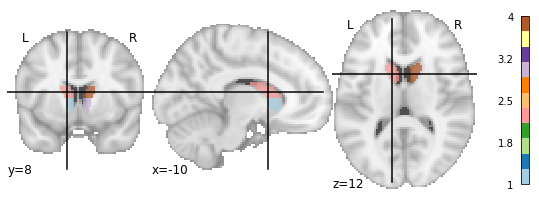

In [11]:
img_caudate = join(dir_mask, 'mask.caudate_4parts.nii')
nilearn.plotting.plot_roi(img_caudate, cmap='Paired', colorbar=True)

In [12]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_caudate, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['lhCN', 'lbCN', 'rhCN', 'rbCN']
)

In [13]:
for subj in tqdm(list_subj):
    ## reward
    img_beta = join(dir_GLM_reward, '%s/%s.Rew#1_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for label, beta in zip(masker.labels, betas):
        ap = 'anterior' if 'h' in label else ('posterior' if 'b' in label else 'invalid')
        lr = 'left' if 'l' in label else ('right' if 'r' in label else 'invalid')
        roi = 'putamen' if 'PU' in label else ('caudate' if 'CN' in label else 'invalid')
        df = df.append(
            {'subj':subj, 'condition':'reward', 'ROI':roi, 'AP':ap, 'LR':lr, 'beta':beta}
            , ignore_index=True
        )
    ## move-stop
    img_beta = join(dir_GLM_movement, '%s/%s.Move-Stop_GLT#0_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for label, beta in zip(masker.labels, betas):
        ap = 'anterior' if 'h' in label else ('posterior' if 'b' in label else 'invalid')
        lr = 'left' if 'l' in label else ('right' if 'r' in label else 'invalid')
        roi = 'putamen' if 'PU' in label else ('caudate' if 'CN' in label else 'invalid')
        df = df.append(
            {'subj':subj, 'condition':'move-stop', 'ROI':roi, 'AP':ap, 'LR':lr, 'beta':beta}
            , ignore_index=True
        )
## validation check
print(df[df=='invalid'].sum())
        
df

100%|██████████| 24/24 [00:00<00:00, 30.97it/s]

subj           0
condition      0
ROI            0
AP             0
LR             0
beta         0.0
dtype: object


,subj,condition,ROI,AP,LR,beta
0,GL03,reward,putamen,anterior,right,0.374774
1,GL03,reward,putamen,anterior,left,0.403717
2,GL03,reward,putamen,posterior,left,0.241160
3,GL03,reward,putamen,posterior,right,0.308857
4,GL03,move-stop,putamen,anterior,right,0.033582
...,...,...,...,...,...,...
379,GL29,reward,caudate,posterior,right,0.068569
380,GL29,move-stop,caudate,anterior,left,-0.000416
381,GL29,move-stop,caudate,posterior,left,0.019312
382,GL29,move-stop,caudate,anterior,right,0.018539


In [14]:
img_striatum = nilearn.image.math_img(img1=img_caudate, formula='img1*0')
img_striatum = nilearn.image.math_img(
    img1=img_striatum, img2=img_caudate, img3=img_putamen
    , formula='img1 + img2 + (img3*10)'
)

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


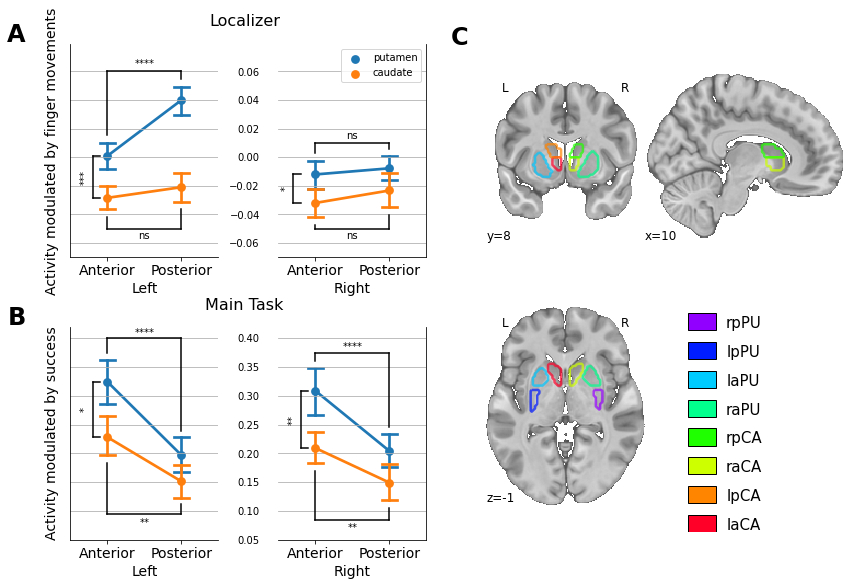

In [15]:
ncols, nrows = 4, 2

fig = plt.figure(figsize=(ncols*3, nrows*4), constrained_layout=False)
gs = fig.add_gridspec(nrows=nrows, ncols=ncols)

axs = []
axs.append(fig.add_subplot(gs[0,0]))
axs.append(fig.add_subplot(gs[0,1]))
axs.append(fig.add_subplot(gs[1,0]))
axs.append(fig.add_subplot(gs[1,1]))
axs.append(fig.add_subplot(gs[:,2:]))
                
############
## Reward ##
############
xlim = [-0.5, 1.5]
xticks = ['Anterior','Posterior']
ylim = [0.05, 0.42]
ylabel = 'Activity modulated by success'
xApart, yApart = 0.1, 0.01

## Left
ax = sns.pointplot(
    data=df[(df.condition=='reward')&(df.LR=='left')], x='AP', y='beta', hue='ROI'
    , capsize=0.2, ci=68
    , ax=axs[2]
)
ax.set_xlabel('Left', fontsize=14)
ax.set_ylabel(ylabel, fontsize=14)
ax.set_xticklabels(xticks, fontsize=14)
ax.set_yticklabels('')
ax.tick_params(axis='y', direction='out', width=0)
ax.get_legend().remove()
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(
    -0.3, 1.1, 'B'
    , transform=ax.transAxes
    , fontsize=24, fontweight='bold', va='top', ha='right'
)

### paired t-test
a = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
x = 0
xLEdge = x - 0.2
ax.plot([x - xApart, xLEdge], [a.mean(), a.mean()], 'k-')
ax.plot([x - xApart, xLEdge], [b.mean(), b.mean()], 'k-')
ax.plot([xLEdge, xLEdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xLEdge-(xApart), 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='posterior')&(df.ROI=='putamen')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 0.40
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
b = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='posterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = 0.095
ax.plot([xL, xL], [a.mean()-(a.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-(b.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xL], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart+0.005), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

## Right
ax = sns.pointplot(
    data=df[(df.condition=='reward')&(df.LR=='right')], x='AP', y='beta', hue='ROI'
    , capsize=0.2, ci=68
    , ax=axs[3]
)
ax.set_xlabel('Right', fontsize=14)
ax.set_xticklabels(xticks, fontsize=14)
ax.set_ylabel('')
ax.tick_params(axis='y', direction='out', width=0, pad=15)
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.get_legend().remove()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

### paired t-test
a = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
x = 0
xLEdge = x - 0.2
ax.plot([x - xApart, xLEdge], [a.mean(), a.mean()], 'k-')
ax.plot([x - xApart, xLEdge], [b.mean(), b.mean()], 'k-')
ax.plot([xLEdge, xLEdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xLEdge-(xApart), 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='posterior')&(df.ROI=='putamen')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 0.375
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
b = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='posterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = 0.085
ax.plot([xL, xL], [a.mean()-(a.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-(b.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xL], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart+0.005), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

###############
## Move-Stop ##
###############
xlim = [-0.5, 1.5]
xticks = ['Anterior','Posterior']
ylim = [-0.07, 0.079]
ylabel = 'Activity modulated by finger movements'
xApart, yApart = 0.1, 0.005

## Left
ax = sns.pointplot(
    data=df[(df.condition=='move-stop')&(df.LR=='left')], x='AP', y='beta', hue='ROI'
    , capsize=0.2, ci=68
    , ax=axs[0]
)
ax.set_xlabel('Left', fontsize=14)
ax.set_ylabel(ylabel, fontsize=14)
ax.set_xticklabels(xticks, fontsize=14)
ax.set_yticklabels('')
ax.tick_params(axis='y', direction='out', width=0)
ax.get_legend().remove()
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(
    -0.3, 1.1, 'A'
    , transform=ax.transAxes
    , fontsize=24, fontweight='bold', va='top', ha='right'
)

### paired t-test
a = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
x = 0
xLEdge = x - 0.2
ax.plot([x - xApart, xLEdge], [a.mean(), a.mean()], 'k-')
ax.plot([x - xApart, xLEdge], [b.mean(), b.mean()], 'k-')
ax.plot([xLEdge, xLEdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xLEdge-(xApart), 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='posterior')&(df.ROI=='putamen')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 0.06
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
b = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='posterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = -0.05
ax.plot([xL, xL], [a.mean()-(a.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-(b.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xL], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

## Right
ax = sns.pointplot(
    data=df[(df.condition=='move-stop')&(df.LR=='right')], x='AP', y='beta', hue='ROI'
    , capsize=0.2, ci=68
    , ax=axs[1]
)
ax.set_xlabel('Right', fontsize=14)
ax.set_xticklabels(xticks, fontsize=14)
ax.set_ylabel('')
ax.tick_params(axis='y', direction='out', width=0, pad=15)
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.legend(loc='upper right')
# ax.legend(bbox_to_anchor=[1.7, .6])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

### paired t-test
a = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
x = 0
xLEdge = x - 0.3
ax.plot([x - (xApart+0.1), xLEdge], [a.mean(), a.mean()], 'k-')
ax.plot([x - (xApart+0.1), xLEdge], [b.mean(), b.mean()], 'k-')
ax.plot([xLEdge, xLEdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xLEdge-(xApart), 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='posterior')&(df.ROI=='putamen')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 0.01
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
b = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='posterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = -0.05
ax.plot([xL, xL], [a.mean()-(a.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-(b.sem()+yApart), yDEdge], 'k-')
ax.plot([xL, xR], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

fig.tight_layout()

## Plotting Nilearn ROIs
display = nilearn.plotting.plot_roi(
    img_striatum, black_bg=False
    , bg_img=bg_img
    , display_mode='tiled', cut_coords=(10,8,-1), draw_cross=False
    , view_type='contours', linewidths=2.5
    , cmap='gist_rainbow'
    , axes=axs[4]
)
plt.text(
    -0.05, 1.038, 'C'
    , transform=axs[4].transAxes
    , fontsize=24, fontweight='bold', va='top', ha='right'
)
# display.add_contours(img_striatum, filled=False, cmap='gist_rainbow')

### legend
rois = ['laCA', 'lpCA', 'raCA', 'rpCA', 'raPU', 'laPU', 'lpPU', 'rpPU']
nax = fig.add_axes([0.8, 0.1, .16, .4])

cmap = get_cmap('gist_rainbow')
colors = np.round(np.linspace(0, cmap.N-1, len(rois)+1)).astype(int)

for ii, roi in enumerate(rois):
    rgb = cmap(colors[ii])
    x, y = 0, 0 + 0.125*ii
    w, h = 0.2, 0.075 
    nax.add_patch(Rectangle((x,y),w , h, facecolor=rgb, edgecolor='k'))
    nax.text(x+.4, y+0.03, roi, fontsize=15, horizontalalignment='center', verticalalignment='center')        
    
nax.axis('off')

## Titles
axs[2].text(
    1.85, 0.47, 'Main Task'
    , fontsize=16, va='top', ha='center'
)
axs[0].text(
    1.85, 0.1, 'Localizer'
    , fontsize=16, va='top', ha='center'
)

######################################
fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/results/GL.GLM.pointplot_with_ROIs.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

In [23]:
tmp = df.groupby(['subj','condition','ROI','LR'], as_index=False).mean()
tmp

,subj,condition,ROI,LR,beta
0,GL03,move-stop,caudate,left,-0.006390
1,GL03,move-stop,caudate,right,0.008190
2,GL03,move-stop,putamen,left,0.075616
3,GL03,move-stop,putamen,right,0.045170
4,GL03,reward,caudate,left,0.189816
...,...,...,...,...,...
187,GL29,move-stop,putamen,right,0.040845
188,GL29,reward,caudate,left,0.053681
189,GL29,reward,caudate,right,0.137089
190,GL29,reward,putamen,left,0.391743


In [34]:
a = tmp[(tmp.condition=='move-stop')&(tmp.ROI=='putamen')&(tmp.LR=='left')]
b = tmp[(tmp.condition=='move-stop')&(tmp.ROI=='caudate')&(tmp.LR=='left')]

print(a.subj.values == b.subj.values)

stats.ttest_rel(a.beta,b.beta)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


Ttest_relResult(statistic=7.74374923976555, pvalue=7.46363344390066e-08)

In [35]:
a = tmp[(tmp.condition=='move-stop')&(tmp.ROI=='putamen')&(tmp.LR=='right')]
b = tmp[(tmp.condition=='move-stop')&(tmp.ROI=='caudate')&(tmp.LR=='right')]

print(a.subj.values == b.subj.values)

stats.ttest_rel(a.beta,b.beta)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


Ttest_relResult(statistic=2.569618455647991, pvalue=0.017134092697494538)

In [36]:
a = df[(df.condition=='reward')&(df.ROI=='putamen')&(df.AP=='anterior')&(df.LR=='left')].beta
b = df[(df.condition=='reward')&(df.ROI=='putamen')&(df.AP=='anterior')&(df.LR=='right')].beta

stats.ttest_rel(a,b)

Ttest_relResult(statistic=1.184993329149648, pvalue=0.24812025488369932)

In [50]:
condition='reward'
roi='putamen'
print(condition, roi)
aov = pg.rm_anova(
    data=df[(df.condition==condition)&(df.ROI==roi)]
    , dv='beta'
    , subject='subj'
    , within=['AP','LR']
    , effsize='np2'
)
aov

reward putamen


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,AP,0.324034,1,23,0.324034,46.851679,5.581416e-07,5.581416e-07,0.670731,1.0
1,LR,0.000426,1,23,0.000426,0.100909,7.536081e-01,7.536081e-01,0.004368,1.0
2,AP * LR,0.003169,1,23,0.003169,2.861164,1.042490e-01,1.042490e-01,0.110636,1.0


In [51]:
condition='reward'
roi='caudate'
print(condition, roi)
aov = pg.rm_anova(
    data=df[(df.condition==condition)&(df.ROI==roi)]
    , dv='beta'
    , subject='subj'
    , within=['AP', 'LR']
    , effsize='np2'
)
aov

reward caudate


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,AP,0.112704,1,23,0.112704,12.103574,0.002029,0.002029,0.344796,1.0
1,LR,0.002646,1,23,0.002646,0.611928,0.442043,0.442043,0.025916,1.0
2,AP * LR,0.001696,1,23,0.001696,0.605409,0.444453,0.444453,0.025647,1.0


In [52]:
condition='move-stop'
roi='putamen'
print(condition, roi)
aov = pg.rm_anova(
    data=df[(df.condition==condition)&(df.ROI==roi)]
    , dv='beta'
    , subject='subj'
    , within=['AP','LR']
    , effsize='np2'
)
aov

move-stop putamen


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,AP,0.011294,1,23,0.011294,29.152617,1.741888e-05,1.741888e-05,0.558987,1.0
1,LR,0.022071,1,23,0.022071,43.530085,9.882383e-07,9.882383e-07,0.654292,1.0
2,AP * LR,0.007269,1,23,0.007269,22.594189,8.608989e-05,8.608989e-05,0.495550,1.0


In [53]:
condition='move-stop'
roi='caudate'
print(condition, roi)
aov = pg.rm_anova(
    data=df[(df.condition==condition)&(df.ROI==roi)]
    , dv='beta'
    , subject='subj'
    , within=['AP', 'LR']
    , effsize='np2'
)
aov

move-stop caudate


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,AP,0.001575,1,23,0.001575,1.959928,0.174866,0.174866,0.078523,1.0
1,LR,0.000207,1,23,0.000207,0.241934,0.627475,0.627475,0.010409,1.0
2,AP * LR,0.000009,1,23,0.000009,0.037927,0.847299,0.847299,0.001646,1.0


In [56]:
tmp = df.groupby(['subj', 'condition', 'ROI'], as_index=False).mean()
tmp

,subj,condition,ROI,beta
0,GL03,move-stop,caudate,0.000900
1,GL03,move-stop,putamen,0.060393
2,GL03,reward,caudate,0.232078
3,GL03,reward,putamen,0.332127
4,GL04,move-stop,caudate,-0.035491
...,...,...,...,...
91,GL27,reward,putamen,0.181328
92,GL29,move-stop,caudate,0.024991
93,GL29,move-stop,putamen,0.049134
94,GL29,reward,caudate,0.095385


In [57]:
a = tmp[(tmp.condition=='reward')&(tmp.ROI=='putamen')]
b = tmp[(tmp.condition=='reward')&(tmp.ROI=='caudate')]
print(len(a),len(b))
print(b.subj.values == a.subj.values)

# np.random.shuffle(a.values)
stats.ttest_rel(a.beta,b.beta)

24 24
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


Ttest_relResult(statistic=3.2900298454425596, pvalue=0.0032062219985296548)

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


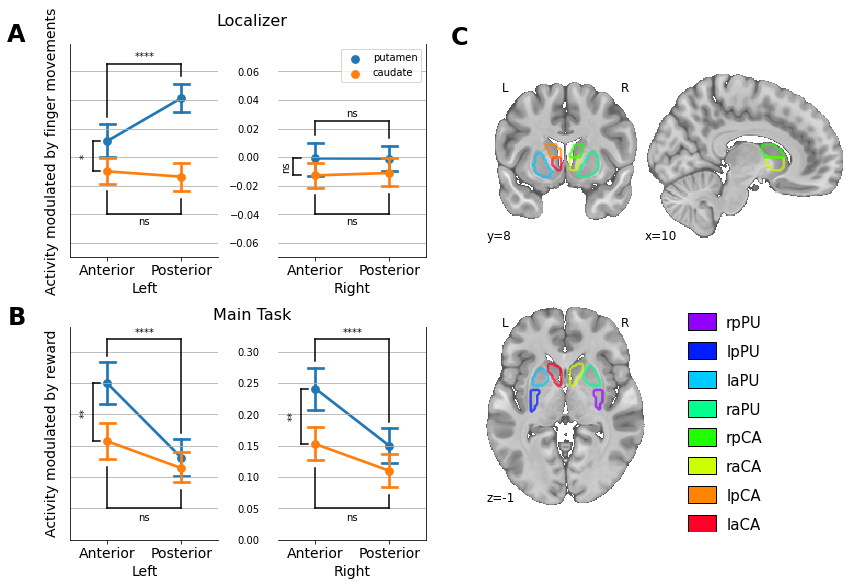

In [18]:
## Source: Sungbeen Park's preprocessed fMRI data

In [15]:
df

,subj,condition,ROI,AP,LR,beta
0,GL03,reward,putamen,anterior,right,0.374774
1,GL03,reward,putamen,anterior,left,0.403717
2,GL03,reward,putamen,posterior,left,0.241160
3,GL03,reward,putamen,posterior,right,0.308857
4,GL03,move-stop,putamen,anterior,right,0.033582
...,...,...,...,...,...,...
379,GL29,reward,caudate,posterior,right,0.068569
380,GL29,move-stop,caudate,anterior,left,-0.000416
381,GL29,move-stop,caudate,posterior,left,0.019312
382,GL29,move-stop,caudate,anterior,right,0.018539


In [31]:
pg.rm_anova(
    data=df
    , dv= 'beta'
    , subject='subj'
    , within=['ROI', 'AP']
    , effsize='np2'
)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,ROI,0.066688,1,23,0.066688,21.918813,0.000103,0.000103,0.487965,1.0
1,AP,0.036005,1,23,0.036005,36.502120,0.000004,0.000004,0.613459,1.0
2,ROI * AP,0.001742,1,23,0.001742,1.815467,0.190979,0.190979,0.073159,1.0


In [25]:
anova = AnovaRM(
    data=df
    , depvar='beta'
    , subject='subj'
    , within=['condition', 'ROI', 'AP', 'LR']
)
print(anova.fit())

                      Anova
                    F Value Num DF  Den DF Pr > F
-------------------------------------------------
condition           44.0586 1.0000 23.0000 0.0000
ROI                 21.9188 1.0000 23.0000 0.0001
AP                  36.5021 1.0000 23.0000 0.0000
LR                   5.1035 1.0000 23.0000 0.0337
condition:ROI        3.1676 1.0000 23.0000 0.0883
condition:AP        55.5689 1.0000 23.0000 0.0000
ROI:AP               1.8155 1.0000 23.0000 0.1910
condition:LR         1.0341 1.0000 23.0000 0.3198
ROI:LR               0.9003 1.0000 23.0000 0.3526
AP:LR                0.0503 1.0000 23.0000 0.8246
condition:ROI:AP     4.8247 1.0000 23.0000 0.0384
condition:ROI:LR     3.0437 1.0000 23.0000 0.0944
condition:AP:LR      7.2272 1.0000 23.0000 0.0131
ROI:AP:LR            1.3066 1.0000 23.0000 0.2648
condition:ROI:AP:LR  2.2768 1.0000 23.0000 0.1449



In [30]:
pg.rm_anova(
    data=df[(df.condition=='move-stop')&(df.ROI=='putamen')]
    , dv= 'beta'
    , subject='subj'
    , within=['AP','LR']
    , effsize='np2'
)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,AP,0.011294,1,23,0.011294,29.152617,1.741888e-05,1.741888e-05,0.558987,1.0
1,LR,0.022071,1,23,0.022071,43.530085,9.882383e-07,9.882383e-07,0.654292,1.0
2,AP * LR,0.007269,1,23,0.007269,22.594189,8.608989e-05,8.608989e-05,0.495550,1.0


---

In [7]:
threshold = 3.291 # This is a z-score for p=0.001

In [8]:
zscore_reward = join('/mnt/ext6/GL/fmri_data/stats/GLM.reward/GL.reward.group.Zscore.n24.nii')
zscore_motor = join('/mnt/ext6/GL/fmri_data/stats/GLM.Move_Stop/GL.move-stop.group.Zscore.n24.nii')

/tmp/ipykernel_1303527/983301442.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


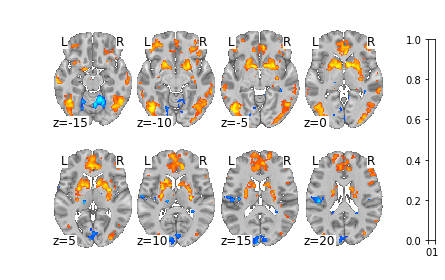

In [53]:
fig, axs = plt.subplots(nrows=2)

cut_coords = range(-15,21,5)
axis = 'z'
cmap=nilearn_cmaps['cold_hot']

display = nilearn.plotting.plot_stat_map(
    stat_map_img=zscore_reward, bg_img=bg_img
    , black_bg=False
    , threshold=threshold
    , symmetric_cbar=True
    , display_mode=axis
#     , display_mode='mosaic'
    , cmap=cmap, colorbar=False
    , cut_coords=cut_coords[:4]
#     , cut_coords=4
    , axes=axs[0]
)

display = nilearn.plotting.plot_stat_map(
    stat_map_img=zscore_reward, bg_img=bg_img
    , black_bg=False
    , threshold=threshold
    , symmetric_cbar=True
    , display_mode=axis
#     , display_mode='mosaic'
    , cmap=cmap, colorbar=False
    , cut_coords=cut_coords[4:]
#     , cut_coords=4
    , axes=axs[1]
)

cax = fig.add_axes([1, .15, .015, .7])
# cbar = fig.colorbar(axs[1], cax=cax)
# cbar.ax.tick_params(labelsize=25)

fig.tight_layout()

---

In [14]:
tmp = nilearn.image.math_img(
    img1=zscore_reward, img2=zscore_motor
    , formula='img1*(img1>%f) - img2*(img2>%f)'%(threshold, threshold)
)


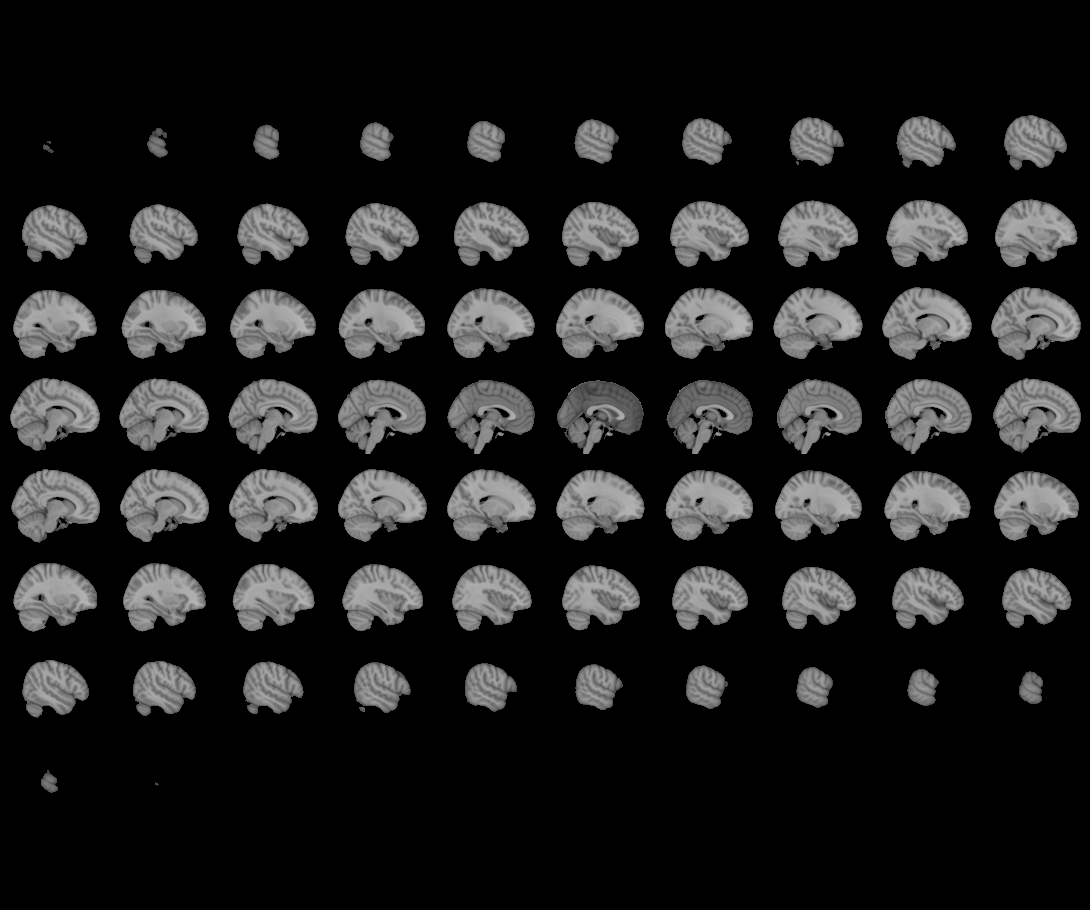
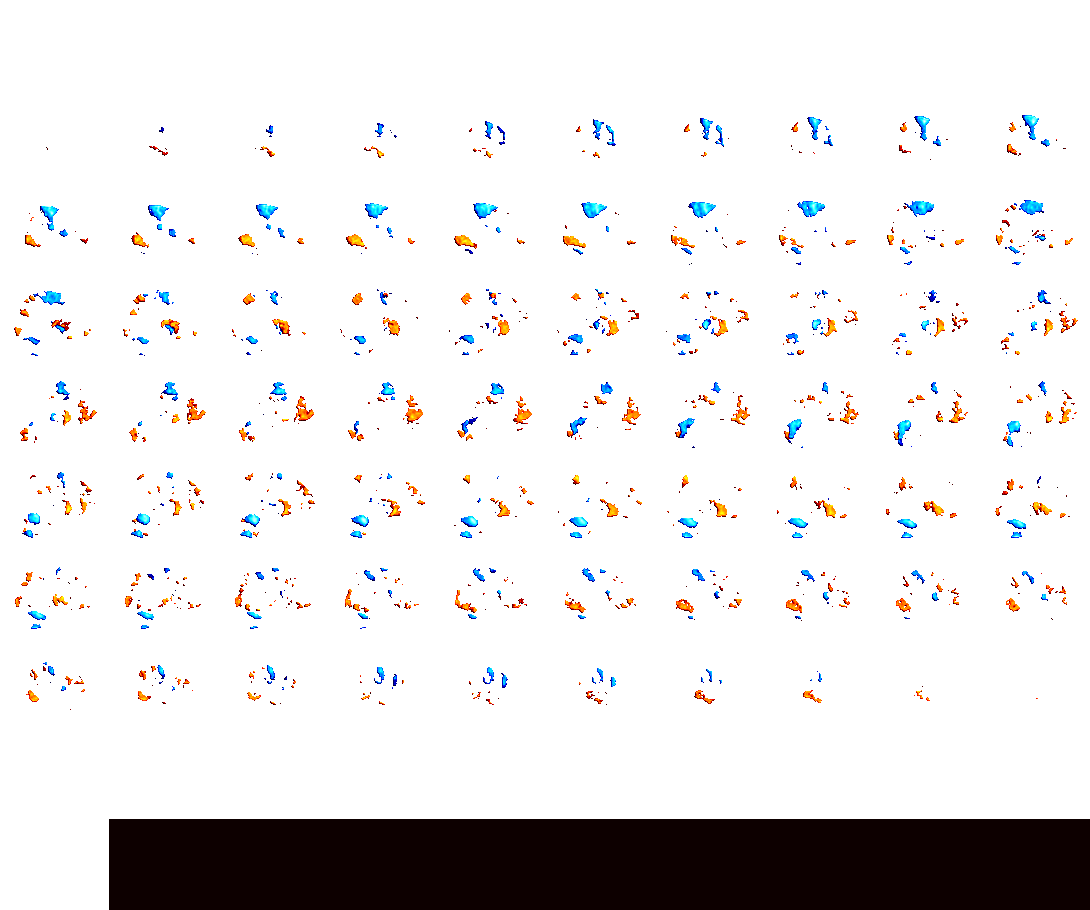

In [16]:
nilearn.plotting.view_img(tmp)

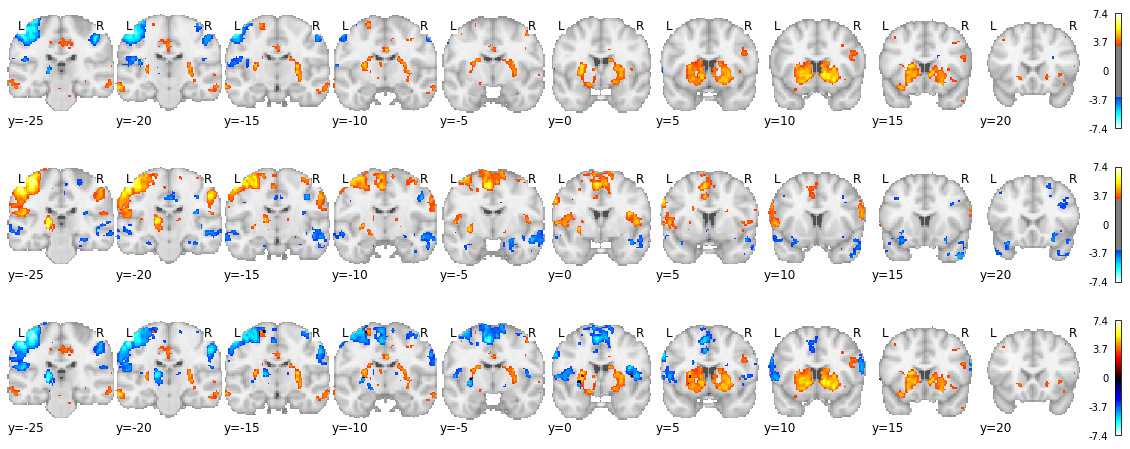

In [19]:
fig, axs = plt.subplots(nrows=3, figsize=(20, 8))

cut_coords = range(-25,21,5)
vmax = 7.4
axis = 'y'
cmap=nilearn_cmaps['cold_hot']

nilearn.plotting.plot_stat_map(
    zscore_reward
    , threshold=threshold
    , symmetric_cbar=True, vmax=vmax
    , display_mode=axis
    , cmap=cmap
    , cut_coords=cut_coords
    , axes=axs[0]
)

nilearn.plotting.plot_stat_map(
    zscore_motor
    , threshold=threshold
    , symmetric_cbar=True, vmax=vmax
    , display_mode=axis
    , cmap=cmap
    , cut_coords=cut_coords
    , axes=axs[1]
)

nilearn.plotting.plot_stat_map(
    tmp
    , symmetric_cbar=True, vmax=vmax
    , display_mode=axis
    , cmap=cmap
    , cut_coords=cut_coords
    , axes=axs[2]
)

# fig.tight_layout()

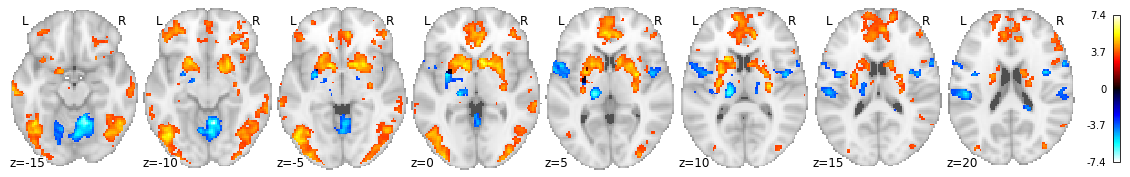

In [17]:
fig, ax = plt.subplots(figsize=(20, 3))

cut_coords = range(-15,21,5)
vmax = 7.4
axis = 'z'
cmap=nilearn_cmaps['cold_hot']

nilearn.plotting.plot_stat_map(
    tmp
    , symmetric_cbar=True, vmax=vmax
    , display_mode=axis
    , cmap=cmap
    , cut_coords=cut_coords
    , axes=ax
)

# fig.tight_layout()

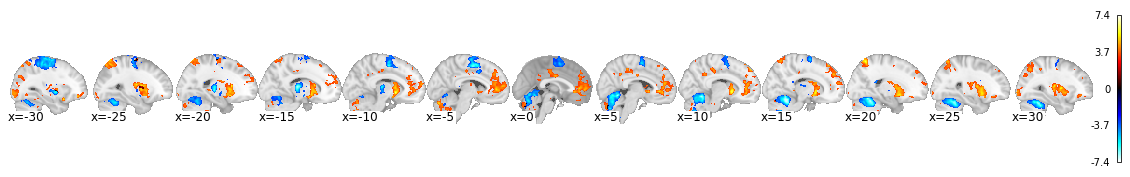

In [18]:
fig, ax = plt.subplots(figsize=(20, 3))

cut_coords = range(-30,31,5)
vmax = 7.4
axis = 'x'
cmap=nilearn_cmaps['cold_hot']

nilearn.plotting.plot_stat_map(
    tmp
    , symmetric_cbar=True, vmax=vmax
    , display_mode=axis
    , cmap=cmap
    , cut_coords=cut_coords
    , axes=ax
)

# fig.tight_layout()

---

In [7]:
dir_glm = '/mnt/ext4/GL/fmri_data/stats/GLM.block_design.4s_shifted.KJH'
list_FB = sorted(glob(join(dir_glm,'statRewSep.GL??.FB.nii')))
list_nFB = sorted(glob(join(dir_glm,'statRewSep.GL??.nFB.nii')))

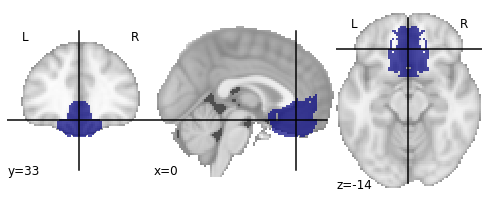

In [8]:
# img_VmPFC = join(dir_mask, 'mask.VmPFC_16parts.nii')
img_VmPFC = nilearn.image.math_img(
    img1=join(dir_mask, 'mask.VmPFC_16parts.nii')
    , formula='img1>0'
)
nilearn.plotting.plot_roi(img_VmPFC)

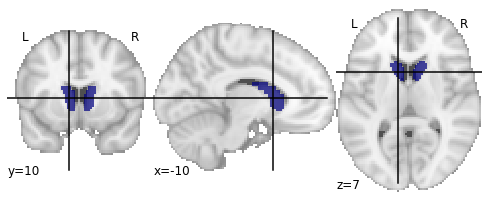

In [9]:
# img_caudate = join(dir_mask, 'mask.caudate_4parts.nii')
img_caudate = nilearn.image.math_img(
    img1= join(dir_mask, 'mask.caudate_4parts.nii')
    , formula='img1>0'
)
nilearn.plotting.plot_roi(img_caudate)

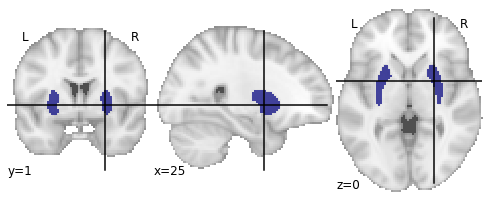

In [10]:
img_putamen = nilearn.image.math_img(
    img1= join(dir_mask, 'mask.putamen.nii')
    , formula='img1>0'
)
nilearn.plotting.plot_roi(img_putamen)

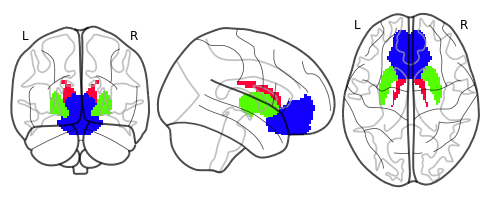

In [11]:
img_mask = nilearn.image.math_img(
    img1=img_caudate, img2=img_VmPFC, img3=img_putamen
    , formula='(img1 - ((img1+img2)>1)) + (img2 - ((img1+img2)>1))*2 + img3*3'
)
nilearn.plotting.plot_glass_brain(img_mask, cmap='prism')

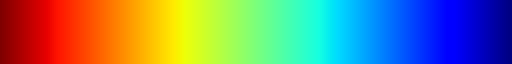

In [12]:
sns.color_palette("jet_r", as_cmap=True)

In [13]:
palette = sns.color_palette("jet_r", 13)
palette

[(0.820855614973262, 0.0, 0.0),
 (1.0, 0.18954248366013082, 0.0),
 (1.0, 0.4509803921568628, 0.0),
 (1.0, 0.7269426289034133, 0.0),
 (0.9456040480708411, 0.9883805374001453, 0.022137887413029734),
 (0.7179000632511068, 1.0, 0.24984187223276413),
 (0.4775458570524983, 1.0, 0.49019607843137264),
 (0.249841872232764, 1.0, 0.717900063251107),
 (0.022137887413030133, 0.9274509803921573, 0.9456040480708411),
 (0.0, 0.6450980392156862, 1.0),
 (0.0, 0.34705882352941175, 1.0),
 (0.0, 0.06470588235294117, 1.0),
 (0.0, 0.0, 0.8208556149732622)]

In [14]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_mask, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['Caudate', 'vmPFC', 'Putamen']
)

In [15]:
df = pd.DataFrame(columns=['subj', 'condition', 'ROI', 'beta'])

## FB
for ii, fname in enumerate(list_FB):
    subj = fname.split('.')[-3]
    betas = masker.fit_transform(fname)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'condition':'FB', 'ROI':roi, 'beta':beta}, ignore_index=True)

## nFB
for ii, fname in enumerate(list_nFB):
    subj = fname.split('.')[-3]
    betas = masker.fit_transform(fname)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'condition':'nFB', 'ROI':roi, 'beta':beta}, ignore_index=True)

df

,subj,condition,ROI,beta
0,GL03,FB,Caudate,0.173552
1,GL03,FB,vmPFC,0.238163
2,GL03,FB,Putamen,0.396890
3,GL04,FB,Caudate,0.400449
4,GL04,FB,vmPFC,0.534183
...,...,...,...,...
139,GL27,nFB,vmPFC,-0.962322
140,GL27,nFB,Putamen,0.470183
141,GL29,nFB,Caudate,0.217427
142,GL29,nFB,vmPFC,0.304593


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


/tmp/ipykernel_79576/1812044000.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


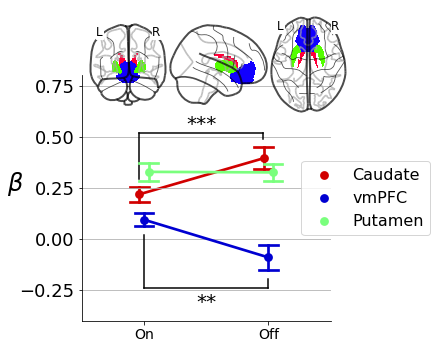

In [17]:
fig, ax = plt.subplots(figsize=(6,4))

# g = sns.violinplot(
#     data=df, x='condition', y='beta', hue='ROI'
#     , order=('FB', 'nFB')
#     , width=.6
#     , palette=sns.color_palette("gist_ncar", len(df.ROI.unique()))
#     , ax=ax
# )
g = sns.pointplot(
    data=df, x='condition', y='beta', hue='ROI'
    , order=('FB', 'nFB'), dodge=True
    , ci=68, capsize=0.15
    , palette=(palette[0], palette[12], palette[6])
    , ax=ax
)
# g.get_legend().remove()
g.legend(bbox_to_anchor=(0.85, 0.5), loc='center left', ncol=1, fontsize=16)
# g.legend(loc='lower left', ncol=1, fontsize=16)
g.grid(axis='y')
g.set_ylabel(r'$\beta$', fontsize=24, rotation=0)
g.set_ylim(-0.4, 0.8)
g.set_xlim(-.5, 1.5)
g.tick_params(axis='both', which='major', labelsize=18)
# # g.hlines(0, xmin=-1, xmax=4, colors='yellow', linestyle='--', linewidth=2)
g.set_xlabel('')
g.set_xticklabels(['On', 'Off'], fontsize=14)
# g.set_title('Cursor Movement / %ss_shifted'%shift)

yApart = 0.04
## paired t-test (Caudate)
shift = -0.04
a = df[(df.ROI=='Caudate')&(df.condition=='FB')]
b = df[(df.ROI=='Caudate')&(df.condition=='nFB')]
print(a.subj.values==b.subj.values)
tval, pval = stats.ttest_rel(a.beta, b.beta)
xL, xR = 0+shift, 1+shift
yUEdge = 0.52
ax.plot([xL, xL], [a.beta.mean()+a.beta.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.beta.mean()+b.beta.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=20
)

## paired t-test (vmPFC)
shift = 0.
a = df[(df.ROI=='vmPFC')&(df.condition=='FB')]
b = df[(df.ROI=='vmPFC')&(df.condition=='nFB')]
print(a.subj.values==b.subj.values)
tval, pval = stats.ttest_rel(a.beta, b.beta)
xL, xR = 0+shift, 1+shift
yDEdge = -0.24
ax.plot([xL, xL], [a.beta.mean()-(a.beta.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xR], [b.beta.mean()-(b.beta.sem()+yApart), yDEdge], 'k-')
ax.plot([xL, xR], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart+0.03), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=20
)

## Bounding box
bbox = g.get_position()
rect = (0.5125-0.3, 0.8, 0.6, 0.4) # (x0, y0, w, h)
ax_insert = fig.add_axes(rect)
nilearn.plotting.plot_glass_brain(img_mask, cmap='prism', axes=ax_insert)

sns.despine()

fig.tight_layout()

In [18]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/results/GL.GLM.block_design.pointplot_with_roi.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)